# <center> Relax Data Science Challenge <center/>

### Table of Contents

1. <a href="#1.-Loading-Data">Loading Data</a>. 
2. <a href="#2.-Data-Wrangling">Data Wrangling</a>.
3. <a href="#3.-Exploratory-Data-Analysis-(EDA)">Exploratory Data Analysis (EDA)</a>.
4. <a href="#4.-Feature-Engineering">Feature Engineering</a>.
5. <a href="#5.-Model-Building">Model Building</a>.
6. <a href="#6.-Conclusion">Conclusion</a>.

# 1. Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# read in the dataset
users = pd.read_csv('data/takehome_users.csv', parse_dates=['creation_time'], encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
# convert unix timestamp of last login to a datetime object
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [4]:
# check for the basic info
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


The columns of `last_session_creation_time` and `invited_by_user_id` have missing values.

In [5]:
# read in the takehome user engagement dataset
engagement = pd.read_csv('data/takehome_user_engagement.csv', parse_dates=['time_stamp'], encoding='latin-1')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
# check for the basic info
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


---------

# 2. Data Wrangling

The goal of this data science challenge is to predict 'adopted user' and adopted user is defined as a user who has logged into the product on three separate days in at least one seven-day period. The takehome_user_engagement dataset or the engagement dataframe here would be used to determine whether a user is adopted or not.

In [7]:
# count how many unique users in our engagment data of the 207,917 entries 
print('There are {} unique users of the 207,917 entries in engagement data.'\
     .format(engagement['user_id'].nunique()))

There are 8823 unique users of the 207,917 entries in engagement data.


In [8]:
# narrowing down users who logged in 3 times in total
three_logins = engagement.groupby('user_id').filter(lambda x: len(x)>=3)
print('There are {} unique users who logged in 3 times or more in total.'\
      .format(three_logins['user_id'].nunique()))

There are 2248 unique users who logged in 3 times or more in total.


In [9]:
three_logins.head(2)

,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


In [10]:
# Remove index
three_logins.reset_index(drop=True, inplace = True)

# Finding how many of the 2248 unique three-logins users are adopted users 
# who have logged in three separate days in at least one 7 day period 
adopted = 0
adopted_users = []
for i in range(len(three_logins)-2):
    user = three_logins['user_id'][i]
    if user != adopted and user == three_logins['user_id'][i+2]:
    # Get start date 
        sd = three_logins['time_stamp'][i]
        # 7 days period end date
        ed = sd + pd.Timedelta('7D')
        if sd < three_logins['time_stamp'][i+1] < ed and sd < three_logins['time_stamp'][i+2] < ed:
            adopted_users.append(user)
            adopted = user

In [11]:
# count how many adopted users there are 
len(adopted_users)

1602

In [12]:
# initiate 'adopted_user' column and set it to 0
users['adopted_user'] = 0

# check if object_id is in adopted_users list: 1 if yes, 0 if no
for row, col in users.iterrows():
    if users.loc[row, 'object_id'] in adopted_users:
        users.loc[row, 'adopted_user'] = 1
    else:
        users.loc[row, 'adopted_user'] = 0

In [13]:
# check the number of adopted users again
users['adopted_user'].value_counts()

0    10398
1     1602
Name: adopted_user, dtype: int64

In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted_user                12000 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(5), object(3)


In [15]:
# fill in missing data for the 'invited_by_user_id' column by transforming the column
users['invited'] = users.invited_by_user_id.apply(lambda x: 0 if np.isnan(x) else 1)

In [16]:
users.invited.value_counts()

1    6417
0    5583
Name: invited, dtype: int64

--------

# 3. Exploratory Data Analysis (EDA)

#####  `opted_in_to_mailing_list` vs `adopted_user`

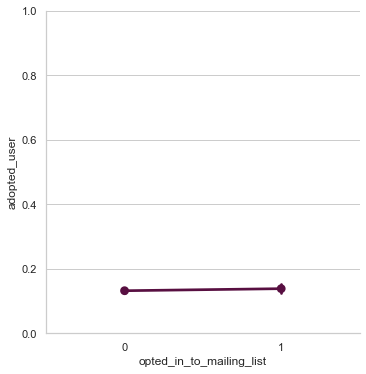

In [17]:
ax1 = sns.PairGrid(data=users, x_vars=['opted_in_to_mailing_list'], y_vars='adopted_user', size=5)
ax1.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
ax1.set(ylim=(0, 1))
plt.show()

As shown by the graph above, users who opted in mailing list has very little to do with ending up as an adopted user.

##### `enabled_for_marketing_drip` vs `adopted_user`

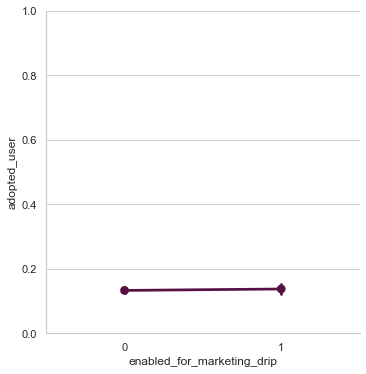

In [18]:
ax2 = sns.PairGrid(data=users, x_vars=['enabled_for_marketing_drip'], y_vars='adopted_user', size=5)
ax2.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
ax2.set(ylim=(0, 1))
plt.show()

Again, marketing drip is not effective in adopting users.

##### `invited` vs `adopted_users`

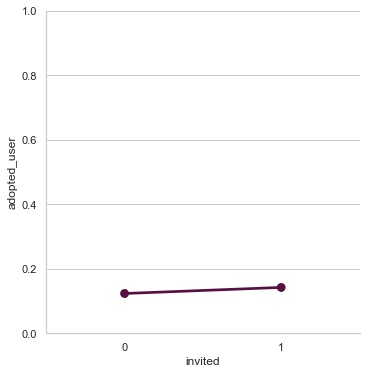

In [19]:
ax3 = sns.PairGrid(data=users, x_vars=['invited'], y_vars='adopted_user', size=5)
ax3.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
ax3.set(ylim=(0, 1))
plt.show()

Users who have invited other users have a slightly larger chance of being an adopted user.

##### `creation_source` vs `adopted_user`

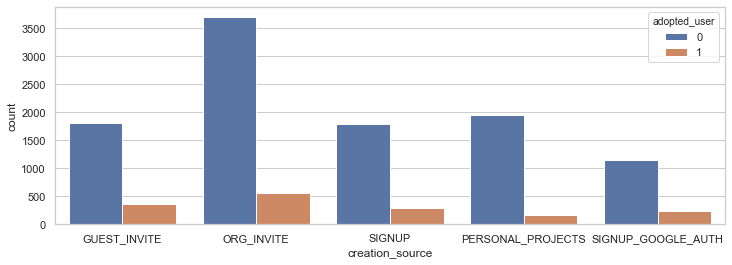

In [20]:
plt.figure(figsize=(12,4))
sns.countplot(x='creation_source', data=users, hue='adopted_user')
plt.show()

Users with the accounts that were created for personal projects are less likely to be adopted compared to the other users.

----------

# 4. Feature Engineering

In [21]:
users = users.set_index('object_id')

In [22]:
# re-code datetime columns to be used in the analysis
users['creation_year'] = users.creation_time.dt.year
users['creation_month'] = users.creation_time.dt.month
users['creation_day'] = users.creation_time.dt.day

users['last_session_creation_time'] = users['last_session_creation_time'].fillna(users['last_session_creation_time'].mean())
users['last_session_year'] = users.last_session_creation_time.dt.year
users['last_session_month'] = users.last_session_creation_time.dt.month
users['last_session_day'] = users.last_session_creation_time.dt.day

In [23]:
# re-code the email columns
users['email'] = users['email'].apply(lambda x: x[x.find('@')+1:])
major_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']
users['email'] = users['email'].apply(lambda x: 'other' if x not in major_domains else x[:x.find('.')])

users['email'].value_counts()

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: email, dtype: int64

In [24]:
# drop the following columns
users.drop(['name', 'org_id', 'invited_by_user_id', 'creation_time', 'last_session_creation_time'], axis=1, inplace=True)

In [25]:
# convert categorical columns to dummy variables
users = pd.get_dummies(users, prefix='is')

In [26]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   opted_in_to_mailing_list    12000 non-null  int64
 1   enabled_for_marketing_drip  12000 non-null  int64
 2   adopted_user                12000 non-null  int64
 3   invited                     12000 non-null  int64
 4   creation_year               12000 non-null  int64
 5   creation_month              12000 non-null  int64
 6   creation_day                12000 non-null  int64
 7   last_session_year           12000 non-null  int64
 8   last_session_month          12000 non-null  int64
 9   last_session_day            12000 non-null  int64
 10  is_cuvox                    12000 non-null  uint8
 11  is_gmail                    12000 non-null  uint8
 12  is_gustr                    12000 non-null  uint8
 13  is_hotmail                  12000 non-null  uint8
 14  is_jou

-----------

# 5. Model Building

Three different machine learning algorithms will be experimented to predict adopted users:

1. Logistic Regression
2. Support Vector Machine Classifier
3. Random Forest Classifier
4. Gradient Boosting Classifier

In [27]:
# extract features and target
X = users.drop('adopted_user', axis=1)
y = users['adopted_user']

In [28]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
# we will list and compare the different algorithms. 
model_evaluation = []

def Evaluation(model, X_test, y_test, y_pred):
    """
    This function is to produce model statistics
    """
    # Append model statistics to model_evaluation list
    roc_auc = roc_auc_score(y_test, y_pred)
    Precision=precision_score(y_test,y_pred)
    Accuracy=accuracy_score(y_test,y_pred)
    Recall=recall_score(y_test,y_pred)
    F1=f1_score(y_test,y_pred)
    model_evaluation.append([model, Accuracy, roc_auc, Precision, Recall, F1])

##### Logistic Regression

In [30]:
# instantiate Pipeline object
logreg = Pipeline([
        ('scaler', StandardScaler()),
        ('logit',LogisticRegression())
    ])

# fit to the training data
logreg.fit(X_train, y_train)

# predict the labels
y_pred = logreg.predict(X_test)

Evaluation('Logistic Regression', X_test, y_test, y_pred)

##### Support Vector Machine

In [31]:
# instantiate Pipeline object
svm = Pipeline([
        ('scaler', StandardScaler()),
        ('SVM', SVC())
    ])

# fit to the training data
svm.fit(X_train, y_train)

# predict the labels
y_pred = svm.predict(X_test)

Evaluation('Support Vector Machine', X_test, y_test, y_pred)

##### Random Forest Classifier

In [32]:
# instantiate Pipeline object
rfc = Pipeline([
        ('scaler', StandardScaler()),
        ('rfc', RandomForestClassifier(class_weight='balanced')) #class_weight='balanced' to adjust for the imbalanced classes
    ])

# fit to the training data
rfc.fit(X_train, y_train)

# predict the labels
y_pred = rfc.predict(X_test)

Evaluation('Random Forest Classifier', X_test, y_test, y_pred)

##### Gradient Boosting Classifier

In [33]:
# instantiate Pipeline object
gbc = Pipeline([
        ('scaler', StandardScaler()),
        ('gbc', GradientBoostingClassifier())
    ])

# fit to the training data
gbc.fit(X_train, y_train)

# predict the labels
y_pred = gbc.predict(X_test)

Evaluation('Gradient Boosting Classifier', X_test, y_test, y_pred)

In [34]:
# prepare a dataframe using all the models with their performance measures
df_eval=pd.DataFrame(model_evaluation,columns=['Model', 'Accuracy', 'ROC_AUC', 'Precision', 'Recall', 'F1'])
df_eval.sort_values(['ROC_AUC'],ascending=False,inplace=True)
df_eval=df_eval.set_index('Model')
df_eval

,Accuracy,ROC_AUC,Precision,Recall,F1
Model,,,,,
Gradient Boosting Classifier,0.971250,0.908053,0.956364,0.821875,0.884034
Random Forest Classifier,0.967500,0.895312,0.951493,0.796875,0.867347
Support Vector Machine,0.948750,0.823678,0.945701,0.653125,0.772643
Logistic Regression,0.944583,0.802764,0.960591,0.609375,0.745698


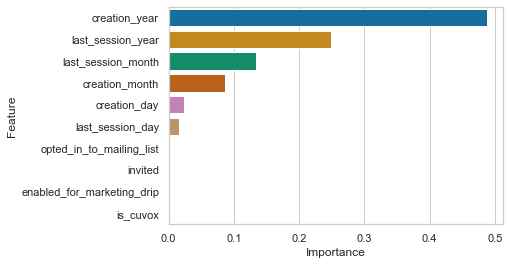

In [35]:
# feature importance ranking
feat = X_train.columns
imp = gbc.named_steps['gbc'].feature_importances_
df_gb = pd.DataFrame({'Feature': feat, 'Importance': imp})[:10]
df_gb = df_gb.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=df_gb, palette='colorblind');

# 6. Conclusion

- The Gradient Boosting Classifier algorithm performs the best in predicting the adopted users with an accuracy score of 97%. It also performs better in all other performance measures compared to the other models.
- As shown on the feature importance ranking above, `creation_time` and `last_session_creation_time` features are the most important features when it comes to predicting the adopted users.  

<a href="#Table-of-Contents">Back to Top</a>